# Oja's Algorithm

## The following cell imports the .db file when run

In [1]:
!ls ../../

CSE4223-ODAS  K_cluster_analysis.db  zoom_amd64.deb


In [2]:
data_dir = "../../K_cluster_analysis.db" # change this according to where your data is kept
!ls -lh $data_dir

-rw-rw-r-- 1 chaitanya chaitanya 576M May 20 21:31 ../../K_cluster_analysis.db


In [3]:
import pandas as pd
import numpy as np
from sklearn import decomposition
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.cluster import KMeans
import glob
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
%%time
#run this to import
try:
    import dill
except:
    %pip install dill
    import dill
dill.load_session(data_dir)
data=data[:,1:]  # remove prefix '1'
data.shape

CPU times: user 104 ms, sys: 488 ms, total: 592 ms
Wall time: 593 ms


(2664671, 12)

From [the fast onvergence of incremental PCA](https://arxiv.org/pdf/1501.03796.pdf)

![](figures/OnlinePCAEquations.png)

### Explanation of Oja's update

* $V_n$ - the estimate of the top eigenvector at iteration $n$
* $\gamma_n$ - learning rate.
* $X_n$ The $n$th example
* $X_n X_n^T V_{n-1} = X_n (X_n \cdot V_{n-1})$

### calc and subtract mean

In [5]:
data[10,:]

array([  nan,   nan,   nan,   nan,   nan,   nan, -0.01,  0.  ,  1.  ,
         nan,   nan,   nan])

In [6]:
# Calculating the mean of the data points
print(data.shape)
data_mean = np.nanmean(data,axis = 0,keepdims = True)
print(data_mean)

# subtracting the means from the data matrix

print(data_mean.shape)

data = data - data_mean

(2664671, 12)
[[-0.02950949  0.00459708  0.95076457  0.1287518  -0.04651903  0.61195448
   0.05075128 -0.11779619  0.93551044  0.25047638 -0.0368738   0.8057973 ]]
(1, 12)


In [7]:
# check that mean is now zero
np.nanmean(data,axis = 0,keepdims = True)

array([[ 1.00129615e-17, -6.22028761e-19,  1.29763140e-16,
         2.22252682e-17, -2.80124212e-17,  1.22557594e-16,
         3.26439482e-18,  7.95596556e-17,  5.16255423e-16,
         7.70841431e-17,  9.97767260e-18,  1.42645399e-16]])

## New idea: set nan to zero after subtructing the mean
After subtracting the mean, we know that the new mean is zero. If we now set all of the nans to zero 
we create a fully defined data with the mean unchanged. Outer product has to be positive semi-definite.

In [8]:
np.sum(isnan(data))

21558675

In [9]:
cdata=np.nan_to_num(data)
np.sum(isnan(cdata))

0

In [10]:
cdata.shape

(2664671, 12)

In [11]:
import pandas as pd
import numpy as np
from sklearn import decomposition
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.cluster import KMeans
import glob

from numpy import linalg as LA

d=12  # dimension
n=cdata.shape[0]
block_size=10000
# calculate covariance matrix

outters = np.zeros((d, d))
for j in range(n):
    outters += np.outer(cdata[j,:],cdata[j,:])
    if j%block_size==0:
        print('\r %d: '%j,end='')
    
_cov = outters/n

#eigen values
eigen_values, eigen_vectors = LA.eig(_cov)


 2660000: 

In [12]:
eigen_values

array([0.07987757, 0.0345566 , 0.02562041, 0.02324271, 0.02034742,
       0.0015321 , 0.00317211, 0.00431054, 0.0060947 , 0.00873081,
       0.01008793, 0.01197347])

In [13]:
eig_val_sorted_indices = np.argsort(eigen_values)
print(eig_val_sorted_indices)
eig_val_sorted_indices = eig_val_sorted_indices[-1::-1]
print(eig_val_sorted_indices)
eig_val_sorted_indices.shape

[ 5  6  7  8  9 10 11  4  3  2  1  0]
[ 0  1  2  3  4 11 10  9  8  7  6  5]


(12,)

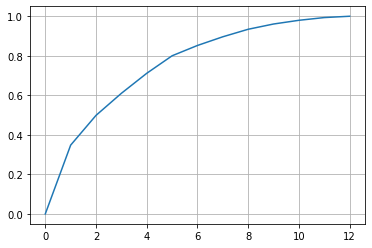

In [14]:
eig_val_ordered=eigen_values[eig_val_sorted_indices]
eig_val_cumul = np.cumsum(eig_val_ordered)
eig_val_cumul /= eig_val_cumul[-1]
plot([0]+list(eig_val_cumul))
grid()

In [15]:
sorted_eigvec = eigen_vectors[:,eig_val_sorted_indices]

1. Understand what format of output of LA.eig(_cov) is - It returns an array of eigenvalues and eigenvectors, such that the ith eigenvalue's eigenvector can be found in eigen_vectors[:i]
2. Get eigenvectors corresponding to the largest eigenvalues
3. Project data onto eigenvectors

We use the equation to project vector a onto vector b:
$ \vec{a_1} = \vec{a}  \frac{\vec{b}}{||\vec{b}||} $

This is the magnitude of the projection vector.

Here we want to project all our data onto our eigenvector. The magnitude is already 1. So we just calculate the dot product of the data with the eigenvector.

Projections are to be made on the mean shifted data.

In [16]:
data.shape, sorted_eigvec.shape

((2664671, 12), (12, 12))

In [17]:
%%time
data_proj_ev1 = np.dot(cdata,sorted_eigvec[:,:2])

CPU times: user 54.6 ms, sys: 16 ms, total: 70.6 ms
Wall time: 64 ms


## Plotting trajectories

In [18]:
N=data_proj_ev1.shape[0]
time_axis = np.arange(N)
type(time_axis)

numpy.ndarray

We create a 3D plot.  
x: projection of mean subtracted data onto largest eigenvector - data_proj_ev1[:,0]  
y: projection of mean subtracted data onto second largest eigenvector - data_proj_ev1[:,0]  
z: time - time interval between samples not known. For now, assuming it to be 1s - time_axis  

In [19]:
from mpl_toolkits import mplot3d

## Next steps

* [x] Make sure that the scaling of the plpots is consistent
* [ ] Contact Ardel (and brian?) to find out what is the status of the translator. You should be able to execture the translator yourself on the raw data. Record the results of translation in a CSV file.
* [ ] Retain the date+tod for the recordings, and use them to color code by hour/minute etc.
* [ ] See if you can find consistent locations (chairs, common places to stand) along a long period of time (weeks)


min to max data limits: -0.5 to 1.5 in the x direction, -1 to +1 in the y direction.

$$sampling\_time = 8 \times 10^{-3} s$$

$$n\_samples = 2.6 \times 10^6 $$

$$ \therefore time\_elapsed = sampling\_rate \times n\_samples = 20800s \approx 5.8 hours$$

In the following plots, each plot represents data for a period of 13 minutes

In [37]:
leftx = -0.5
rightx = 1.5
lefty = -1
righty = 1

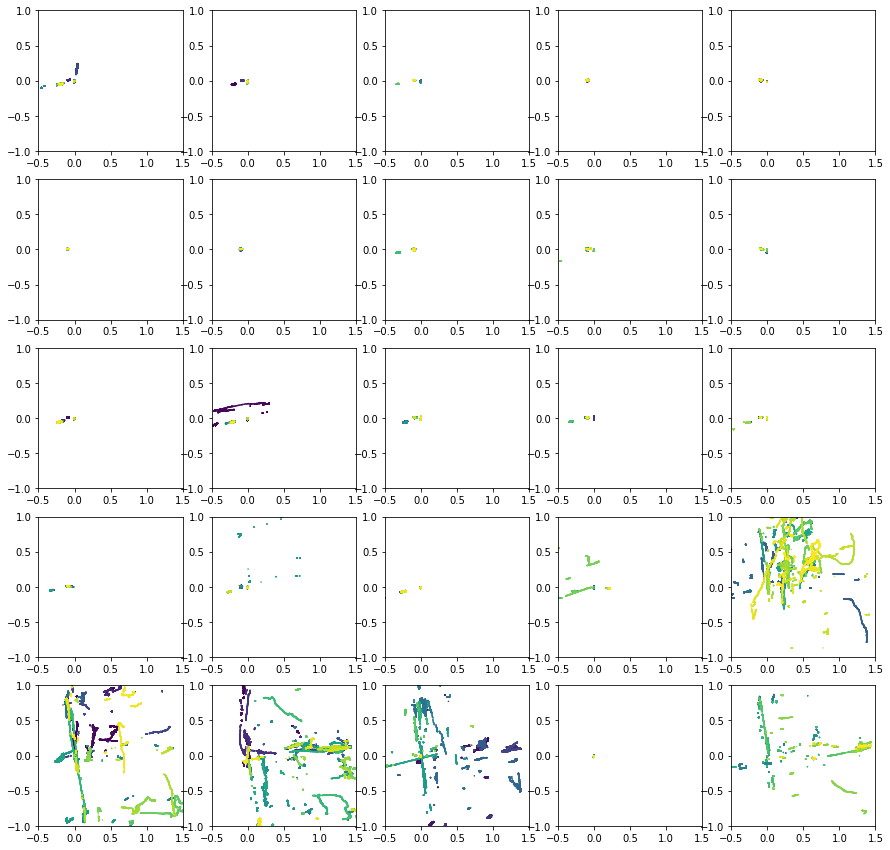

In [38]:
figure(figsize=[15,15])
Length=100000

i=1
for T1 in range(0,N,Length):
    subplot(5,5,i)
    scatter(data_proj_ev1[T1:T1+Length,0], data_proj_ev1[T1:T1+Length,1],marker='.',s=1,c=np.arange(T1,T1+Length))
    plt.xlim(leftx,rightx)
    plt.ylim(lefty,righty)
    i=i+1
    if (i>25):
        break

### Looking closer at the last six plots ( approximately 1.3 hours)

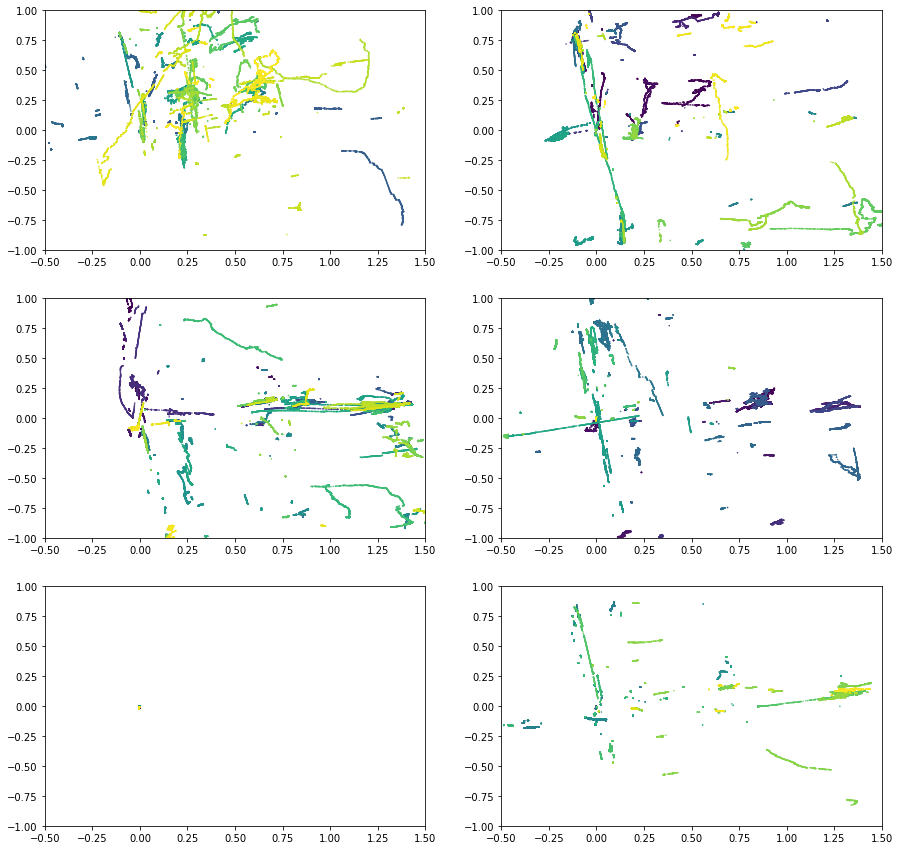

In [44]:
figure(figsize=[15,15])
Length=100000

i=1
for T1 in range(Length*19,N,Length):
    subplot(3,2,i)
    scatter(data_proj_ev1[T1:T1+Length,0], data_proj_ev1[T1:T1+Length,1],marker='.',s=1,c=np.arange(T1,T1+Length))
    plt.xlim(leftx,rightx)
    plt.ylim(lefty,righty)
    i=i+1
    if (i>6):
        break

In [ ]:
three_d_plot = plt.figure()
new_axis = three_d_plot.add_subplot(111,projection = '3d')
new_axis.plot(data_proj_ev1[T1:T2,0], data_proj_ev1[T1:T2,1],time_axis[T1:T2])
new_axis.set_xlabel('X Coordinate')
new_axis.set_ylabel('Y Coordinate')
new_axis.set_zlabel('Time')

## Generating a more intuitive plot

In [ ]:
import ipywidgets
begin_time = ipywidgets.IntSlider(min=0, max=2500000, step=100000, value=0)
end_time = ipywidgets.IntSlider(min=100000, max=2600000, step=100000, value=100000)

In [ ]:
begin_time

In [ ]:
end_time

In [ ]:
three_d_plot = plt.figure()
new_axis = three_d_plot.add_subplot(111,projection = '3d')
new_axis.plot(data_proj_ev1[begin_time.value:end_time.value,0], data_proj_ev1[begin_time.value:end_time.value,1],time_axis[begin_time.value:end_time.value])
new_axis.set_xlabel('X Coordinate')
new_axis.set_ylabel('Y Coordinate')
new_axis.set_zlabel('Time')



# References:
# 1. https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html
# 2. https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html
# 3. A helpful video for understanding widgets: https://www.youtube.com/watch?v=i40d8-Hu4vM

## Old Oja-based code

In [ ]:
v_next_Nr = np.zeros((12))

vList=[]
varList=[]

for i in range(data.shape[0]):
    
    gamma_oja = 0.0001 # max(0.00001,1/(i+1)) # fixing learning rate [1]
    
    # Implementing Oja's rule equation
    # It involves an inner product. In the presence of NaNs, we look at it as
    # elementwise multiplication followed by nansum
    # Then we have a multiplication of gamma and the dot product with the current vector
    # We also add the previous weight vector to this.
    
    # we calculate the second term of the sum first
    _dot=np.nansum(np.multiply(data[i,:],v))
    oja_term_2 = gamma_oja * data[i,:] * _dot
    
    # we find which the indices of elements that not nan
    _not_nan_term_2=~isnan(oja_term_2)
    
    # only updating those terms of the numerator which are not NaN
    v_next_Nr[_not_nan_term_2] = v[_not_nan_term_2] + oja_term_2[_not_nan_term_2]

    v_next_Dr = np.linalg.norm(v_next_Nr)
#     if(i%100000==0):
#         print('the denominator is', v_next_Dr)
    v_next = v_next_Nr/v_next_Dr

    
    v = v_next
    vList.append(v)
    varList.append(_dot**2)
    if(i%100000==0):
        print("%d\t"%i+' '.join(["%5.4f"%x for x in v]))

In [ ]:
varList=np.array(varList)
varList.shape
plot(varList);

In [ ]:
vstack=np.stack(vList)

vstack.shape

In [ ]:
step=10000
diffs=vstack[step:,:]-vstack[:-step,:]
change=np.sqrt(np.sum(diffs**2,axis=1))
plot(change);

### Obtaining the second second eigenvector

1. 'v' is the current eigenvector
2. project each point i onto v. call this projection i_proj_v
3. subtract, for each point, i_proj_v from i

In [ ]:
v

We use the equation to project vector a onto vector b:
$ \vec{a_1} = \vec{a}  \frac{\vec{b}}{||\vec{b}||} $

This is the magnitude of the projection vector.

In [ ]:
# projecting i_1 onto v

data_perp_1 = np.zeros(data.shape)

v_mag = np.linalg.norm(v)

v_unit_vector = v/v_mag

for j in range(data.shape[0]):

    i_1 = data[j,:]

    proj_num = np.nansum(np.multiply(i_1,v))

    proj_not_nan = ~isnan(i_1)

    proj_den = np.linalg.norm(v[proj_not_nan])

    proj_mag = proj_num/proj_den

    proj_vector = proj_mag * v_unit_vector

    # print(proj_vector)

    # subtracting projection from datapoint

    data_perp_1[j,proj_not_nan] = i_1[proj_not_nan] - proj_vector[proj_not_nan]
    

### Oja's rule for second matrix

In [ ]:
# calculating the mean of data_perp_1 and subtracting it from the data


print(data_perp_1.shape)
data_perp_1_mean = np.nanmean(data_perp_1,axis = 0,keepdims = True)
print(data_perp_1_mean)

# subtracting the means from the data matrix

print(data_perp_1_mean.shape)

data_perp_1 = data_perp_1 - data_perp_1_mean

In [ ]:
v_2= np.random.normal(0, 1, size = 12)
# print(v)
v_2 = v_2 / 10000
# print(v)

v_next_Nr_2 = np.zeros((12))


for i in range(data.shape[0]):
    
    gamma_oja_2 = max(0.001,1/(i+1)) # fixing learning rate [1]
    
    # Implementing Oja's rule equation
    # It involves an inner product. In the presence of NaNs, we look at it as
    # elementwise multiplication followed by nansum
    # Then we have a multiplication of gamma and the dot product with the current vector
    # We also add the previous weight vector to this.
    
    # we calculate the second term of the sum first
    oja_2_term_2 = gamma_oja_2 * data_perp_1[i,:] * np.nansum(np.multiply(data_perp_1[i,:],v_2))
    
    # we find which the indices of elements that not nan
    _not_nan_2_term_2=~isnan(oja_2_term_2)
    
    # only updating those terms of the numerator which are not NaN
    v_next_Nr_2[_not_nan_2_term_2] = v_2[_not_nan_2_term_2] + oja_2_term_2[_not_nan_2_term_2]

#     if(i == 0):
#         print('At the 1st iteration, numerator is ',v_next_Nr)
#     if(i%100000==0):
#         print('the numerator is', v_next_Nr)
#     not_nn_oja = ~isnan(v_next_Nr)

    v_next_Dr_2 = np.linalg.norm(v_next_Nr_2)
#     if(i%100000==0):
#         print('the denominator is', v_next_Dr)
    v_next_2 = v_next_Nr_2/v_next_Dr_2

    v_2 = v_next_2
    if(i%100000==0):
        print(i,v_2)

In [ ]:
# for a symmetric matrix eigenvectors must be normal
dot_prod_ev = np.dot(v,v_2)
print(dot_prod_ev)

In [ ]:
v2= np.random.normal(0, 1, size = 12)
print(v2)
v3= np.random.normal(0, 1, size = 12)
print(v3)

In [ ]:
print(_not_nan_term_2)

In [ ]:
print(v2[_not_nan_term_2])

In [ ]:
print(v3[_not_nan_term_2])

In [ ]:
v4 = np.zeros((12))
print(v4)

In [ ]:
v4[_not_nan_term_2] = (v3[_not_nan_term_2]) + (v2[_not_nan_term_2])

In [ ]:
print(v2,v3,v4)

In [ ]:
print(v2[_not_nan_term_2],v3[_not_nan_term_2],v4[_not_nan_term_2])

In [ ]:
_not_nan_term_2

### References (links):

1. https://arxiv.org/pdf/1501.03796.pdf